# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [13]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [14]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 500 samples from 5 classes.


# Exploratory Data analysis
## Class distribution


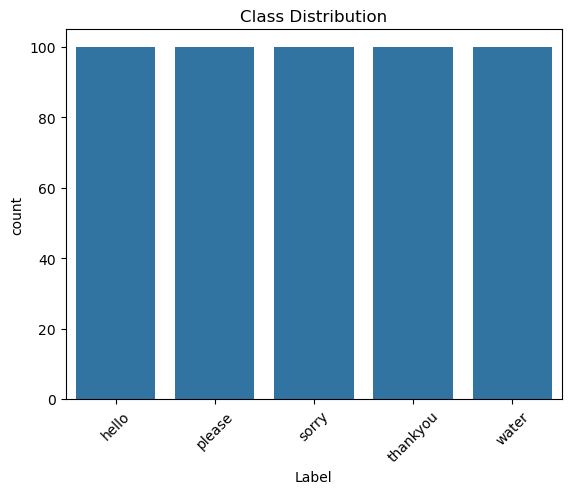

In [15]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 350, Val: 75, Test: 75


# Build model

In [18]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,189 (801.52 KB)

 Trainable params: 205,189 (801.52 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [19]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3101 - loss: 1.5224

22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.3211 - loss: 1.5083 - val_accuracy: 0.5867 - val_loss: 1.0125
Epoch 2/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5848 - loss: 1.0272

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5871 - loss: 1.0201 - val_accuracy: 0.6933 - val_loss: 0.8580
Epoch 3/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6675 - loss: 0.8276

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6701 - loss: 0.8233 - val_accuracy: 0.8267 - val_loss: 0.6044
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7591 - loss: 0.5656

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7600 - loss: 0.5648 - val_accuracy: 0.8933 - val_loss: 0.4409
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8255 - loss: 0.4815

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8237 - loss: 0.4832 - val_accuracy: 0.8400 - val_loss: 0.3621
Epoch 6/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8574 - loss: 0.4233

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8564 - loss: 0.4243 - val_accuracy: 0.9200 - val_loss: 0.3166
Epoch 7/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8835 - loss: 0.3440

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8852 - loss: 0.3415 - val_accuracy: 0.8933 - val_loss: 0.2389
Epoch 8/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8524 - loss: 0.3771

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8541 - loss: 0.3749 - val_accuracy: 0.9733 - val_loss: 0.1711
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9693 - loss: 0.1603 - val_accuracy: 0.9467 - val_loss: 0.1774
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8801 - loss: 0.3623 - val_accuracy: 0.9067 - val_loss: 0.2346
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8834 - loss: 0.3606 - val_accuracy: 0.9067 - val_loss: 0.2140
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9120 - loss: 0.2552 - val_accuracy: 0.9467 - val_loss: 0.1768
Epoch 13/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9474 - loss: 0.1866

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9477 - loss: 0.1864 - val_accuracy: 0.9733 - val_loss: 0.1009
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9625 - loss: 0.1566 - val_accuracy: 0.9333 - val_loss: 0.2372
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9523 - loss: 0.1350 - val_accuracy: 0.9733 - val_loss: 0.1078
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9731 - loss: 0.1084 - val_accuracy: 0.9600 - val_loss: 0.1047
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9802 - loss: 0.1120 - val_accuracy: 0.9600 - val_loss: 0.1020
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9824 - loss: 0.0971 - val_accuracy: 0.9467 - val_loss: 0.1661
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9508 - loss: 0.1315 - val_accuracy: 0.9467 - val_loss: 0.1390
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9843 - loss: 0.0936 - val_accuracy: 0.9600 - val_l

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9775 - loss: 0.0806 - val_accuracy: 0.9733 - val_loss: 0.0874
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9563 - loss: 0.1697 - val_accuracy: 0.7733 - val_loss: 0.7270
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8209 - loss: 0.5562 - val_accuracy: 0.9067 - val_loss: 0.2422
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9360 - loss: 0.2152 - val_accuracy: 0.9467 - val_loss: 0.1722
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9800 - loss: 0.0746

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9802 - loss: 0.0746 - val_accuracy: 0.9733 - val_loss: 0.0812
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9816 - loss: 0.0702 - val_accuracy: 0.9600 - val_loss: 0.1595
Epoch 27/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9832 - loss: 0.0544

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9835 - loss: 0.0537 - val_accuracy: 0.9733 - val_loss: 0.0753
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9992 - loss: 0.0221 - val_accuracy: 0.9600 - val_loss: 0.1555
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9811 - loss: 0.0725 - val_accuracy: 0.9733 - val_loss: 0.0799
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9721 - loss: 0.1394 - val_accuracy: 0.9733 - val_loss: 0.0944
Epoch 31/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9871 - loss: 0.0425

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9870 - loss: 0.0437 - val_accuracy: 0.9867 - val_loss: 0.0554
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9633 - loss: 0.1098 - val_accuracy: 0.9733 - val_loss: 0.1030
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9924 - loss: 0.0630 - val_accuracy: 0.9600 - val_loss: 0.1814
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9887 - loss: 0.0568 - val_accuracy: 0.9467 - val_loss: 0.2278
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9774 - loss: 0.0628 - val_accuracy: 0.9867 - val_loss: 0.0557
Epoch 36/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0163

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9998 - loss: 0.0173 - val_accuracy: 0.9867 - val_loss: 0.0493
Epoch 37/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9967 - loss: 0.0208

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9965 - loss: 0.0210 - val_accuracy: 0.9867 - val_loss: 0.0398
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9800 - loss: 0.0635 - val_accuracy: 0.9467 - val_loss: 0.1790
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8967 - loss: 0.3679 - val_accuracy: 0.9200 - val_loss: 0.2499
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9468 - loss: 0.1503 - val_accuracy: 0.9733 - val_loss: 0.0689
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9784 - loss: 0.0745 - val_accuracy: 0.9600 - val_loss: 0.0776
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9940 - loss: 0.0355 - val_accuracy: 0.9467 - val_loss: 0.1449
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9901 - loss: 0.0379 - val_accuracy: 0.9733 - val_loss: 0.0434
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9914 - loss: 0.0446 - val_accuracy: 0.9333 - val_l

# Plot training history

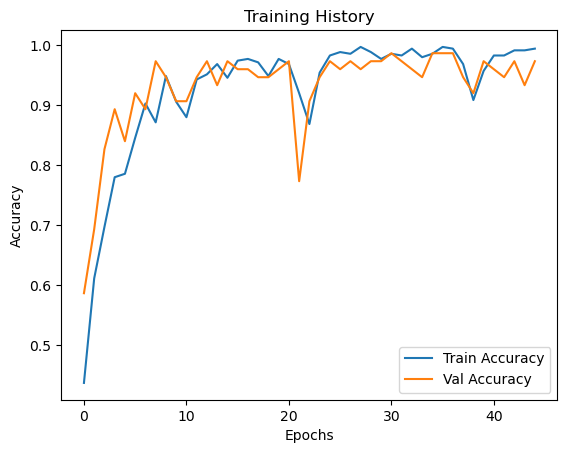

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9816 - loss: 0.0777
Test Accuracy: 0.9867
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step

Classification Report:
              precision    recall  f1-score   support

       hello       0.94      1.00      0.97        15
      please       1.00      1.00      1.00        15
       sorry       1.00      0.93      0.97        15
    thankyou       1.00      1.00      1.00        15
       water       1.00      1.00      1.00        15

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



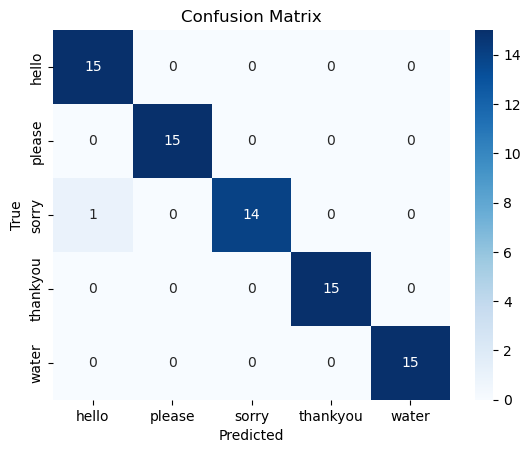

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [22]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
